In [12]:
!pip install prophet xgboost scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error

c:\Users\IMAM\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.1 MB 2.8 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/12.1 MB 2.8 MB/s eta 0:00:04
   ------ --------------------------------- 2.1/12.1 MB 2.7 MB/s eta 0:00:04
   -------- ------------------------------- 2.6/12.1 MB 2.7 MB/s eta 0:00:04
   ----------- ---------------------------- 3.4/12.1 MB 2.8 MB/s eta 0:00:04
   ------------- -------------------------- 4.2/12.1 MB 3.0 MB/s eta 0:00:03
   --------------- ------------------------ 4.7/12.1 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 5.2/12.1 MB 2.9 MB/s eta 0:00:03
   ------------------- -------------------- 5.8/12.1 MB 2.9 MB/s eta 0:00:03
   -------------------- ------------------- 6.3/12.1 MB 2.9 MB/s eta 0:00:03
   ----------------------- ---------------- 7.1/12.1 MB 2.9 MB/s eta 0:00:02
   ----------

In [13]:
df = pd.read_csv('data/processed/alpenbank_ready_for_model.csv', parse_dates=['Date'], index_col='Date')
features_var = ['GDP_Growth', 'Unemployment', 'EUR_CHF'] # Variabel Makro Struktural
target_xgb = 'Default_Rate' # Target Prediksi Machine Learning

# Rentang tanggal prediksi (6 bulan ke depan)

In [14]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=32), periods=6, freq='MS')

# Vector Autoregression

In [15]:
model_var = VAR(df[features_var])
results_var = model_var.fit(maxlags=3)

c:\Users\IMAM\miniforge3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
lag_order = results_var.k_ar
fc_var = results_var.forecast(y=df[features_var].values[-lag_order:], steps=6)
df_var_fc = pd.DataFrame(fc_var, index=future_dates, columns=features_var)

# PROPHET

In [17]:
def run_prophet(series, periods=6):

    df_p = series.reset_index().rename(columns={'Date': 'ds', series.name: 'y'})
    m = Prophet(yearly_seasonality=True, daily_seasonality=False)
    m.fit(df_p)
    future = m.make_future_dataframe(periods=periods, freq='MS')
    forecast = m.predict(future)
    return forecast['yhat'].tail(periods).values

# Prediksi CPI & SNB Rate pakai Prophet

In [18]:
pred_cpi = run_prophet(df['CPI_YoY'])
pred_rate = run_prophet(df['SNB_Policy_Rate'])

20:31:49 - cmdstanpy - INFO - Chain [1] start processing
20:31:49 - cmdstanpy - INFO - Chain [1] done processing
20:31:50 - cmdstanpy - INFO - Chain [1] start processing
20:31:50 - cmdstanpy - INFO - Chain [1] done processing


# Gabungann hasil VAR dan Prophet menjadi "Baseline Macro Forecast"

In [19]:
df_baseline = df_var_fc.copy()
df_baseline['CPI_YoY'] = pred_cpi
df_baseline['SNB_Policy_Rate'] = pred_rate

In [20]:
feature_order = ['CPI_YoY', 'SNB_Policy_Rate', 'GDP_Growth', 'Unemployment']
df_baseline = df_baseline[feature_order]

print("Baseline Macro Forecast (Gabungan VAR + Prophet)")

Baseline Macro Forecast (Gabungan VAR + Prophet)


# XGBOOST REGRESSION

In [21]:
X_train = df[feature_order]
y_train = df[target_xgb]

reg_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
reg_xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
scenarios = {}

# Skenario 1: Baseline (Hasil Murni VAR + Prophet)
scenarios['Baseline'] = df_baseline.copy()

# Skenario 2: Stress Scenario (Inflasi Tinggi, Euro Lemah)
df_stress = df_baseline.copy()
df_stress['CPI_YoY'] += 1.5           # Shock Inflasi
df_stress['SNB_Policy_Rate'] += 1.0   # Bank Sentral panik naikkan bunga
df_stress['GDP_Growth'] -= 1.5        # Ekonomi melambat
df_stress['Unemployment'] *= 1.1      # Pengangguran naik 10%
scenarios['Stress'] = df_stress

# Skenario 3: Optimistic Scenario (Pertumbuhan Bagus)
df_optimis = df_baseline.copy()
df_optimis['GDP_Growth'] += 0.8       # Ekonomi tumbuh
df_optimis['Unemployment'] *= 0.9     # Pengangguran turun
df_optimis['CPI_YoY'] = 1.5           # Inflasi stabil di target ideal
scenarios['Optimistic'] = df_optimis

# STRATEGI & FINAL OUTPUT

In [23]:
def determine_strategy(row, scenario_name):
    rekomendasi = ""
    
    rate = row['SNB_Policy_Rate']
    default_pred = row['Predicted_Default_Rate']
    # contoh skenario strateginys
    if scenario_name == 'Stress':
        rekomendasi = "STOP Kredit Konsumtif. Fokus Kolektibilitas. Tahan Likuiditas."
    elif default_pred > 1.3:
        rekomendasi = "Waspada NPL. Perketat Scoring (Cutoff 750+)."
    elif rate > 1.75:
        rekomendasi = "Dorong KPR Fixed Rate. Lock dana nasabah jangka panjang."
    else:
        rekomendasi = "EKSPANSI. Tawarkan Bunga Promo & Kredit Usaha."
        
    return rekomendasi

print("\n" + "="*50)
print("   LAPORAN STRATEGI ALPENBANK (MULTI-MODEL)   ")
print("="*50)

final_dfs = []

for name, data in scenarios.items():
    # Inilah kelebihan ML: Kita bisa tahu dampak skenario ekonomi ke risiko bank
    data['Predicted_Default_Rate'] = reg_xgb.predict(data[feature_order])
    
    # Tentukan Strategi
    data['Strategi_Recomendation'] = data.apply(lambda row: determine_strategy(row, name), axis=1)
    data['Scenario'] = name
    
    final_dfs.append(data)
    
    # Ex per Skenario
    print(f"\nSKENARIO: {name.upper()}")
    print(f"   Rata-rata Rate SNB  : {data['SNB_Policy_Rate'].mean():.2f}%")
    print(f"   Prediksi NPL (Risk) : {data['Predicted_Default_Rate'].mean():.2f}%")
    print(f"   Strategi Utama      : {data['Strategi_Recomendation'].iloc[0]}")


   LAPORAN STRATEGI ALPENBANK (MULTI-MODEL)   

SKENARIO: BASELINE
   Rata-rata Rate SNB  : -0.55%
   Prediksi NPL (Risk) : 1.23%
   Strategi Utama      : EKSPANSI. Tawarkan Bunga Promo & Kredit Usaha.

SKENARIO: STRESS
   Rata-rata Rate SNB  : 0.45%
   Prediksi NPL (Risk) : 1.26%
   Strategi Utama      : STOP Kredit Konsumtif. Fokus Kolektibilitas. Tahan Likuiditas.

SKENARIO: OPTIMISTIC
   Rata-rata Rate SNB  : -0.55%
   Prediksi NPL (Risk) : 1.09%
   Strategi Utama      : EKSPANSI. Tawarkan Bunga Promo & Kredit Usaha.


# Gabungan Hasil

In [24]:
full_report = pd.concat(final_dfs)
full_report.to_csv('outputs/AlpenBank_Advanced_Strategy.csv')

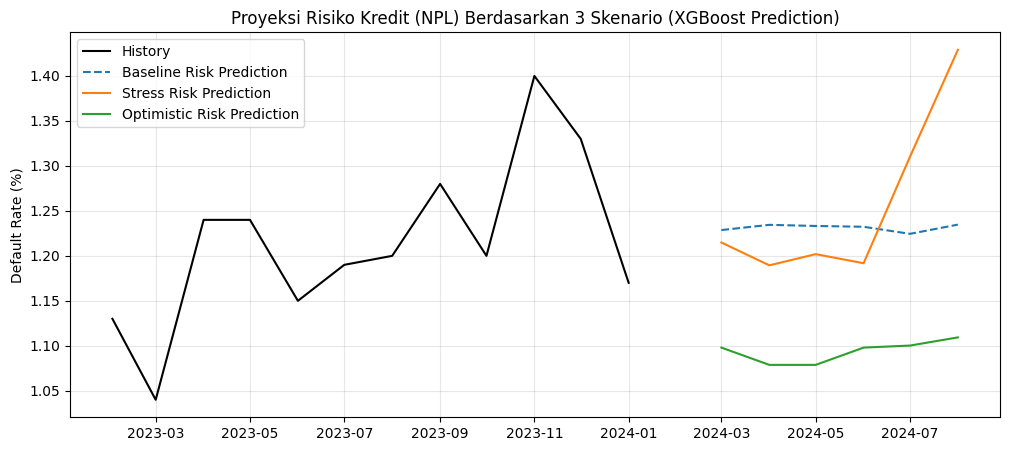


Selesai. Filenya di 'outputs/AlpenBank_Advanced_Strategy.csv'


In [25]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[-12:], df['Default_Rate'][-12:], label='History', color='black')
for name, data in scenarios.items():
    linestyle = '--' if name == 'Baseline' else '-'
    plt.plot(data.index, data['Predicted_Default_Rate'], label=f'{name} Risk Prediction', linestyle=linestyle)

plt.title('Proyeksi Risiko Kredit (NPL) Berdasarkan 3 Skenario (XGBoost Prediction)')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nSelesai. Filenya di 'outputs/AlpenBank_Advanced_Strategy.csv'")